# Clustering Consulting Project

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content//spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
import numpy as np
import pandas as pd
from io import StringIO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('SparkML_Hacking').getOrCreate()

In [ ]:
spark

In [ ]:
hackDataSchema = StructType([

                 StructField("Session_Connection_Time",DoubleType(),True),
                 StructField("Bytes_Transferred",DoubleType(),True),
                 StructField("Kali_Trace_Used",StringType(),True),
                 StructField("Servers_Corrupted",DoubleType(),True),
                 StructField("Pages_Corrupted",DoubleType(),True),
                 StructField("Location",StringType(),True),
                 StructField("WPM_Typing_Speed",DoubleType(),True)
                ])

In [ ]:
hackDF = spark.read.format('csv')\
.option('header','true')\
.option('inferSchema','true')\
.load("/content/drive/MyDrive/hack_data.csv", schema= hackDataSchema)

In [ ]:
hackDF.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [ ]:
hackDF.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes_Transferred: double (nullable = true)
 |-- Kali_Trace_Used: string (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [ ]:
hackDF.cache()

DataFrame[Session_Connection_Time: double, Bytes_Transferred: double, Kali_Trace_Used: string, Servers_Corrupted: double, Pages_Corrupted: double, Location: string, WPM_Typing_Speed: double]

In [ ]:
hackDF.take(2)

[Row(Session_Connection_Time=8.0, Bytes_Transferred=391.09, Kali_Trace_Used='1', Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37),
 Row(Session_Connection_Time=20.0, Bytes_Transferred=720.99, Kali_Trace_Used='0', Servers_Corrupted=3.04, Pages_Corrupted=9.0, Location='British Virgin Islands', WPM_Typing_Speed=69.08)]

In [ ]:
len(hackDF.columns)

7

In [ ]:
hackDF.count()

334

In [ ]:
hackDF.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes_Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [ ]:
from pandas.io.formats.info import DataFrameInfo
df = hackDF.na.drop(how = "any")
print("Count of the  records in the datset before dropping null values ", hackDF.count())
print("Count of the records in the dataset after dropping null values", df.count())

Count of the  records in the datset before dropping null values  334
Count of the records in the dataset after dropping null values 334


In [ ]:
!pip install -q pyspark
!pip install -q handyspark

     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 51.2 MB/s 


In [ ]:
from handyspark import *
from handyspark.sql.pandas import HandyPandas

In [ ]:
hdf = df.toHandy()
hdf.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

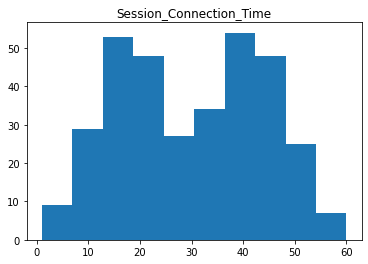

In [ ]:
hdf.cols["Session_Connection_Time"].hist()

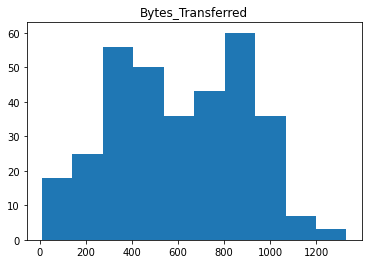

In [ ]:
hdf.cols["Bytes_Transferred"].hist()

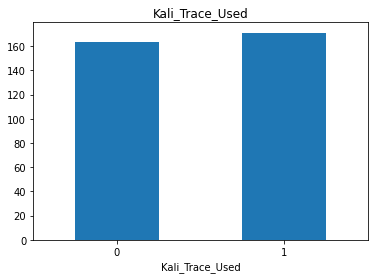

In [ ]:
hdf.cols["Kali_Trace_Used"].hist()

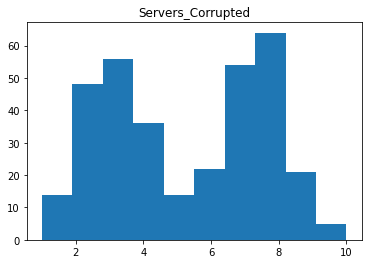

In [ ]:
hdf.cols["Servers_Corrupted"].hist()

# servers corrupted have to be partitionied into two

In [ ]:

from pyspark.sql.functions import when

In [ ]:
hdf = hdf.withColumn("Servers_Corrupted", when(hdf.Servers_Corrupted <= 5,"1")
                                 .when(hdf.Servers_Corrupted >= 5,"2"))


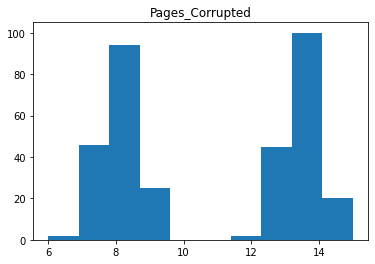

In [ ]:
hdf.cols["Pages_Corrupted"].hist()

# pages corrupted have to be partitionied into three

In [ ]:
hdf = hdf.withColumn("Pages_Corrupted", when(hdf.Pages_Corrupted <= 10,"1")
                                 .when(hdf.Pages_Corrupted >= 10,"2"))

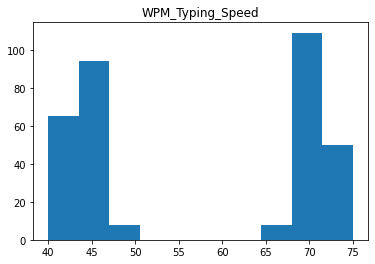

In [ ]:
hdf.cols["WPM_Typing_Speed"].hist()

# WPM Typing Speed have to be partitionied into three

In [ ]:
hdf = hdf.withColumn("WPM_Typing_Speed", when(hdf.WPM_Typing_Speed <= 55,"1")
                                 .when(hdf.WPM_Typing_Speed >= 55,"2"))

In [ ]:
hdf = hdf.drop("Location")

In [ ]:
hdf.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
|                    8.0|           391.09|              1|                1|              1|               2|
|                   20.0|           720.99|              0|                1|              1|               2|
|                   31.0|           356.32|              1|                1|              1|               2|
|                    2.0|           228.08|              1|                1|              1|               2|
|                   20.0|            408.5|              0|                1|              1|               2|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
o

In [ ]:
hdf.dtypes

[('Session_Connection_Time', 'double'),
 ('Bytes_Transferred', 'double'),
 ('Kali_Trace_Used', 'string'),
 ('Servers_Corrupted', 'double'),
 ('Pages_Corrupted', 'double'),
 ('WPM_Typing_Speed', 'double')]

In [ ]:
hdf = hdf.withColumn("Servers_Corrupted",hdf.Servers_Corrupted.cast(StringType()))
hdf = hdf.withColumn("Pages_Corrupted",hdf.Pages_Corrupted.cast(StringType()))
hdf = hdf.withColumn("WPM_Typing_Speed",hdf.WPM_Typing_Speed.cast(StringType()))

In [ ]:
(trainingData,testingData) = hdf.randomSplit([0.75,0.25],seed = 123)

In [ ]:
trainingData.count()

254

In [ ]:
testingData.count()

80

In [ ]:
trainingData.dtypes

[('Session_Connection_Time', 'double'),
 ('Bytes_Transferred', 'double'),
 ('Kali_Trace_Used', 'string'),
 ('Servers_Corrupted', 'string'),
 ('Pages_Corrupted', 'string'),
 ('WPM_Typing_Speed', 'string')]

In [ ]:
cat_Var_names = ['Kali_Trace_Used',"Servers_Corrupted","Pages_Corrupted",'WPM_Typing_Speed']
num_var_names = ["Session_Connection_Time","Bytes_Transferred"]

In [ ]:
from pyspark.ml.feature import VectorAssembler
vector_assembler_numVars = VectorAssembler(inputCols=num_var_names , outputCol="num_features_all")

In [ ]:
from pyspark.ml.feature import MinMaxScaler
min_max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all",outputCol="scaled_num_features")

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
indexers_Cat = [StringIndexer(inputCol=cat_var_name,outputCol="{0}_index".format(cat_var_name),handleInvalid = "keep")
                for cat_var_name in cat_Var_names]

encoders_Cat = [OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_vec".format(indexer.getInputCol())) for indexer in indexers_Cat]

assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders_Cat],outputCol="cat_features")

In [ ]:
assembler = VectorAssembler(inputCols=["scaled_num_features","cat_features"],outputCol="features")

In [ ]:
preprocessingStages = [vector_assembler_numVars] + [min_max_Scalar_NumVars] + indexers_Cat + encoders_Cat + [assembler_Cat] + [assembler]

In [ ]:
preprocessingStages

[VectorAssembler_df958e51cdc0,
 MinMaxScaler_35f2185b02c7,
 StringIndexer_86d61cb5aea9,
 StringIndexer_e66bdcf3244e,
 StringIndexer_91431bfb9d59,
 StringIndexer_c01921000c3f,
 OneHotEncoder_ae5f122132d8,
 OneHotEncoder_39d43d6cb339,
 OneHotEncoder_1f2f24a7023a,
 OneHotEncoder_ed30c5f3d605,
 VectorAssembler_bc98dc77af84,
 VectorAssembler_f980b40ef718]

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# kmeans model on 3 class

In [ ]:
kmeans_3 = KMeans()\
            .setK(3)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

In [ ]:
from pyspark.ml import Pipeline
kmeans_pipeline_1 = Pipeline(stages=preprocessingStages+[kmeans_3])
kmeans_pipeline_model_1= kmeans_pipeline_1.fit(trainingData)

In [ ]:
train_predictions_kmeans_1 = kmeans_pipeline_model_1.transform(trainingData)

In [ ]:
test_predictions_kmeans_1 = kmeans_pipeline_model_1.transform(testingData)

In [ ]:
train_predictions_kmeans_1.show()

+-----------------------+-----------------+---------------+-----------------+---------------+----------------+----------------+--------------------+---------------------+-----------------------+---------------------+----------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|WPM_Typing_Speed|num_features_all| scaled_num_features|Kali_Trace_Used_index|Servers_Corrupted_index|Pages_Corrupted_index|WPM_Typing_Speed_index|Kali_Trace_Used_vec|Servers_Corrupted_vec|Pages_Corrupted_vec|WPM_Typing_Speed_vec|        cat_features|            features|cluster|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------+----------------+--------------------+---------------------+-----------------------+---------------------+----------------------+---------------

In [ ]:
train_predictions_kmeans_1.select("cluster").distinct().collect()

[Row(cluster=1), Row(cluster=2), Row(cluster=0)]

In [ ]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window

In [ ]:
train_predictions_kmeans_1.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   57|
|      2|   65|
|      0|  132|
+-------+-----+



In [ ]:
test_predictions_kmeans_1.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   22|
|      2|   23|
|      0|   35|
+-------+-----+



In [ ]:
evaluator = ClusteringEvaluator()
evaluator.setPredictionCol("cluster")

ClusteringEvaluator_6d866077108d

In [ ]:
evaluator.evaluate(train_predictions_kmeans_1)

0.8797469582568016

In [ ]:
evaluator.evaluate(test_predictions_kmeans_1)

0.8981850390085414

# kmeans on 2 class model

In [ ]:
kmeans_2 = KMeans()\
            .setK(2)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

In [ ]:
from pyspark.ml import Pipeline
kmeans_pipeline_2 = Pipeline(stages=preprocessingStages+[kmeans_2])
kmeans_pipeline_model_2= kmeans_pipeline_2.fit(trainingData)

In [ ]:
train_predictions_kmeans_2 = kmeans_pipeline_model_2.transform(trainingData)
test_predictions_kmeans_2 = kmeans_pipeline_model_2.transform(testingData)

In [ ]:
train_predictions_kmeans_2.select("cluster").distinct().collect()

[Row(cluster=1), Row(cluster=0)]

In [ ]:
test_predictions_kmeans_2.select("cluster").distinct().collect()

[Row(cluster=1), Row(cluster=0)]

In [ ]:

a= train_predictions_kmeans_2.groupBy('cluster').count()

a = a.withColumn('percent', (f.col('count')*100)/f.sum('count').over(Window.partitionBy()))

a= a.orderBy('percent', ascending=False)

a.select("cluster","count",round("percent",2)).show()

+-------+-----+-----------------+
|cluster|count|round(percent, 2)|
+-------+-----+-----------------+
|      0|  132|            51.97|
|      1|  122|            48.03|
+-------+-----+-----------------+



In [ ]:


a= test_predictions_kmeans_2.groupBy('cluster').count()

a = a.withColumn('percent', (f.col('count')*100)/f.sum('count').over(Window.partitionBy()))

a= a.orderBy('percent', ascending=False)

a.select("cluster","count",round("percent",2)).show()

+-------+-----+-----------------+
|cluster|count|round(percent, 2)|
+-------+-----+-----------------+
|      1|   45|            56.25|
|      0|   35|            43.75|
+-------+-----+-----------------+



In [ ]:
evaluator = ClusteringEvaluator()
evaluator.setPredictionCol("cluster")

ClusteringEvaluator_266d82e4fd71

In [ ]:
evaluator.evaluate(train_predictions_kmeans_2)

0.8379686807238484

In [ ]:
evaluator.evaluate(test_predictions_kmeans_2)

0.8437790424105861

#Silhouette Coefficient:

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.

0: Means clusters are indifferent, or we can say that the distance between    clusters is not significant.

-1: Means clusters are assigned in the wrong way.

# If the no of hackers are two then percentage of hacker1 and hacker2 is almost equal and around 50

# so that we finally conclude  there are only 2 hackers that attacked Technology firm
# since Silhouette Coefficient is almost around 0.9 so we can say
#  Means clusters are well apart from each other and clearly distinguished.